In [ ]:
#Task-2 PART 1 PCA

Training loop - 0
Training Epoch - 1
Accuracy - 79.197
Training Epoch - 2
Accuracy - 91.777
Training Epoch - 3
Accuracy - 93.577
Training Epoch - 4
Accuracy - 94.498
Training Epoch - 5
Accuracy - 94.937
Training Epoch - 6
Accuracy - 95.202
Training Epoch - 7
Accuracy - 95.502
Training Epoch - 8
Accuracy - 95.810
Training Epoch - 9
Accuracy - 96.040
Training Epoch - 10
Accuracy - 96.178
Training Epoch - 11
Accuracy - 96.338
Training Epoch - 12
Accuracy - 96.470
Training Epoch - 13
Accuracy - 96.493
Training Epoch - 14
Accuracy - 96.553
Training Epoch - 15
Accuracy - 96.630
Training Epoch - 16
Accuracy - 96.857
Training Epoch - 17
Accuracy - 96.882
Training Epoch - 18
Accuracy - 96.987
Training Epoch - 19
Accuracy - 97.060
Training Epoch - 20
Accuracy - 97.063
Training Epoch - 21
Accuracy - 97.105
Training Epoch - 22
Accuracy - 97.310
Training Epoch - 23
Accuracy - 97.213
Training Epoch - 24
Accuracy - 97.248
Training Epoch - 25
Accuracy - 97.417
Training Epoch - 26
Accuracy - 97.422
Tra

/local_scratch/slurm.703769/ipykernel_1831843/2701314226.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', final_pca.shape[0])  # You can try other colormaps like 'plasma', 'inferno', etc.
/local_scratch/slurm.703769/ipykernel_1831843/2701314226.py:120: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap), label='Accuracy')


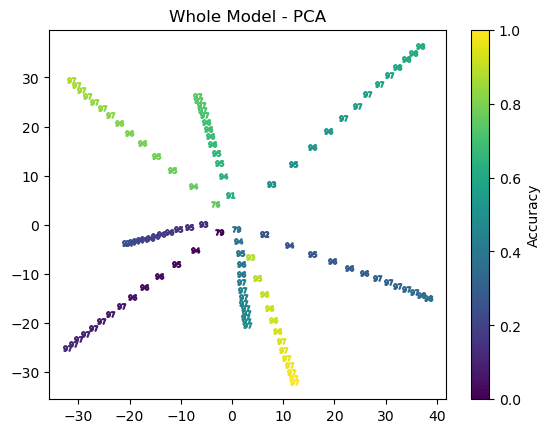

/local_scratch/slurm.703769/ipykernel_1831843/2701314226.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_layer = cm.get_cmap('plasma', final_pca.shape[0])
/local_scratch/slurm.703769/ipykernel_1831843/2701314226.py:143: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap_layer), label='Accuracy')


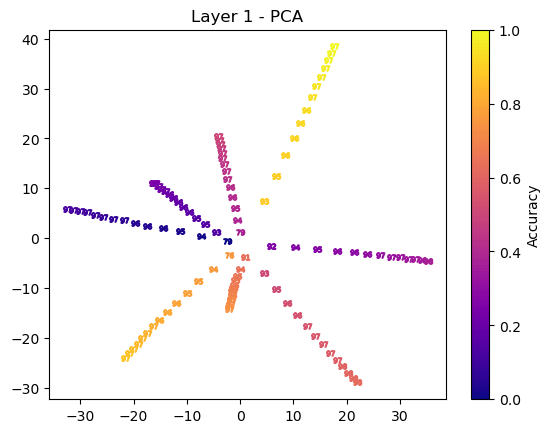

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize data transformers
transformers = transforms.Compose([transforms.ToTensor()])

def data_load(train_batch_size, test_batch_size):
    train_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=True, download=True, transform=transformers),
        batch_size=train_batch_size, shuffle=True)

    test_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=False, download=True, transform=transformers),
        batch_size=test_batch_size, shuffle=True)

    return train_data_loader, test_data_loader

# Define the neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(784, 18)
        self.linear_2 = nn.Linear(18, 20)
        self.linear_3 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x)
        return x

def train_model(model, train_data, optimizer):
    model.train()
    loss_arr = []
    accuracy_arr = []
    total_df = pd.DataFrame()

    for epoch in range(1, 41):  # Match the epoch format you initially provided
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        print(f"Training Epoch - {epoch}")

        for index, (data, target) in enumerate(train_data):
            optimizer.zero_grad()
            data = data.view(-1, 784)  # Flatten MNIST images
            prediction = model(data)
            loss = loss_func(prediction, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            total_samples += target.size(0)
            prediction_data = np.argmax(prediction.data, axis=1)
            correct_samples += (prediction_data == target).sum().item()

        accuracy = (correct_samples / total_samples) * 100
        loss_arr.append(total_loss)
        accuracy_arr.append(round(accuracy, 3))
        print(f'Accuracy - {accuracy:.3f}')

        # Collect weights
        df = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                ws = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                df = pd.concat([df, pd.DataFrame(ws).T], axis=1)

        total_df = pd.concat([total_df, df], axis=0)

    return loss_arr, accuracy_arr, total_df

# Load data
train_data, test_data = data_load(1000, 1000)
loss_func = nn.CrossEntropyLoss()

# Train the model and collect data
total_w_df = pd.DataFrame()
total_accuracy = []
total_loss = []

for i in range(8):
    print(f'Training loop - {i}')
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_arr, accuracy_arr, w_df = train_model(model, train_data, optimizer)
    total_loss.extend(loss_arr)
    total_accuracy.extend(accuracy_arr)
    total_w_df = pd.concat([total_w_df, w_df])

# Perform PCA on the whole model
df = np.array(total_w_df)
pca = PCA(n_components=2)
pca_ = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_, columns=['x', 'y'])
pca_df["accuracy"] = total_accuracy
pca_df["loss"] = total_loss
import matplotlib.cm as cm

# Final PCA for the whole model
final_pca = pca_df.iloc[::3, :]  # Keep every 3rd row for visualization

# Generate a colormap for colors based on accuracy
cmap = cm.get_cmap('viridis', final_pca.shape[0])  # You can try other colormaps like 'plasma', 'inferno', etc.

for i in range(final_pca.shape[0]):
    m = final_pca['accuracy'].iloc[i]  # Access the 'accuracy' column correctly
    color = cmap(i)  # Get color from colormap
    plt.scatter(final_pca['x'].iloc[i], final_pca['y'].iloc[i], marker=f'${int(m)}$', color=color)
    plt.title("Whole Model - PCA")

plt.colorbar(cm.ScalarMappable(cmap=cmap), label='Accuracy')
plt.show()

# PCA for Layer 1
layer_1 = total_w_df.iloc[:, 0:9408]
df = layer_1.to_numpy()
pca = PCA(n_components=2)
new_data = pca.fit_transform(df)
df = pd.DataFrame(new_data, columns=['x', 'y'])
df['accuracy'] = total_accuracy
df['loss'] = total_loss

final_pca = df.iloc[::3, :]  # Keep every 3rd row for visualization

# Generate another colormap for Layer 1 PCA
cmap_layer = cm.get_cmap('plasma', final_pca.shape[0])

for i in range(final_pca.shape[0]):
    m = final_pca['accuracy'].iloc[i]  # Access the 'accuracy' column correctly
    color = cmap_layer(i)  # Get color from colormap for layer 1
    plt.scatter(final_pca['x'].iloc[i], final_pca['y'].iloc[i], marker=f'${int(m)}$', color=color)
    plt.title("Layer 1 - PCA")

plt.colorbar(cm.ScalarMappable(cmap=cmap_layer), label='Accuracy')
plt.show()

# final_pca = pca_df.iloc[::3, :]
# for i in range(final_pca.shape[0]):
#     m = list(final_pca['accuracy'])[i]
#     plt.scatter(final_pca['x'][i], final_pca['y'][i], marker=f'${int(m)}$', color='purple')
#     plt.title("Whole Model - PCA")

# plt.show()

# # Perform PCA on Layer 1
# layer_1 = total_w_df.iloc[:, 0:9408]
# df = layer_1.to_numpy()
# pca = PCA(n_components=2)
# new_data = pca.fit_transform(df)
# df = pd.DataFrame(new_data, columns=['x', 'y'])
# df['accuracy'] = total_accuracy
# df['loss'] = total_loss

# final_pca = df.iloc[::3, :]
# for i in range(final_pca.shape[0]):
#     m = list(final_pca['accuracy'])[i]
#     plt.scatter(final_pca['x'][i], final_pca['y'][i], marker=f'${int(m)}$', color='darkblue')
#     plt.title("Layer 1 - PCA")

# plt.show()

# # Display total number of parameters in the model
# param_model = Model()
# total_params = sum(p.numel() for p in param_model.parameters())
# print("Total number of parameters in the model:", total_params)


In [ ]:
#Task-2 PART 2 GRADIANT NORM

Beginning training
Epoch - 0, Loss - 0.1037
Epoch - 400, Loss - 0.0055
Epoch - 800, Loss - 0.0054
Epoch - 1200, Loss - 0.0054
Epoch - 1600, Loss - 0.0054
Epoch - 2000, Loss - 0.0054
Epoch - 2400, Loss - 0.0054
Training Completed


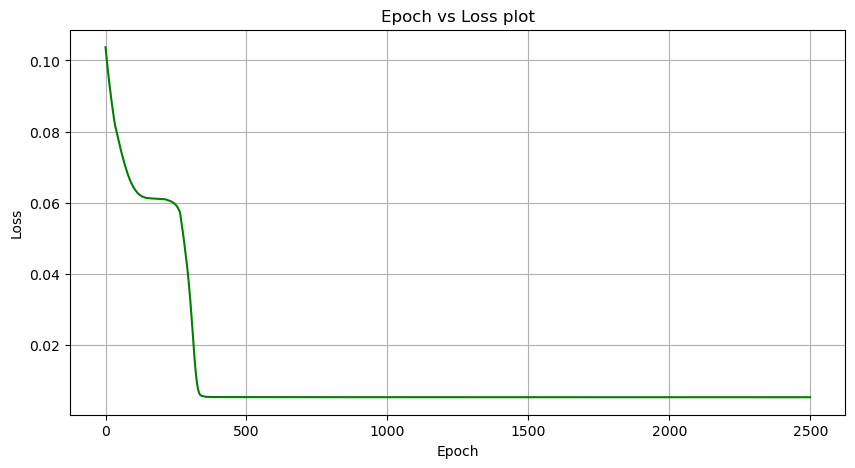

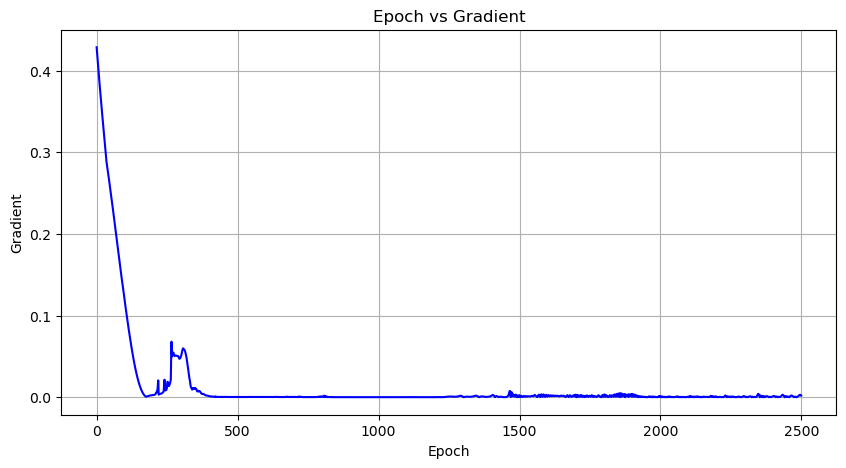

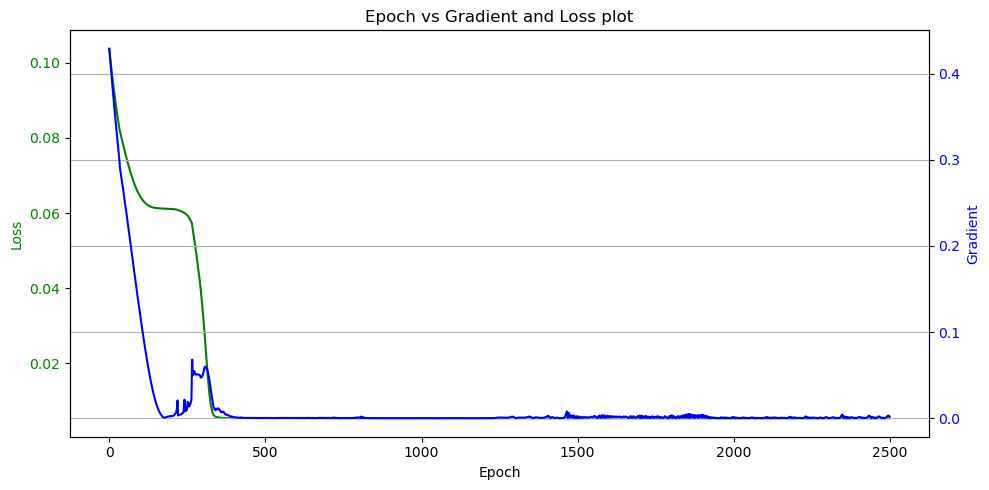

In [8]:
#Task_2_Gradient_norm
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Define the input
ip = np.expand_dims(np.arange(-1.5, 1.5, 0.01), 1)

# Use sinc() function to generate output
op = np.sinc(5 * ip)

# Convert numpy arrays to tensors
x = torch.tensor(ip, dtype=torch.float32)
y = torch.tensor(op, dtype=torch.float32)

# Define the neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(1, 4)
        self.l2 = nn.Linear(4, 9)
        self.l3 = nn.Linear(9, 12)
        self.l4 = nn.Linear(12, 10)
        self.l5 = nn.Linear(10, 10)
        self.l6 = nn.Linear(10, 10)
        self.l7 = nn.Linear(10, 4)
        self.l8 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.l1(x))
        x = nn.functional.leaky_relu(self.l2(x))
        x = nn.functional.leaky_relu(self.l3(x))
        x = nn.functional.leaky_relu(self.l4(x))
        x = nn.functional.leaky_relu(self.l5(x))
        x = nn.functional.leaky_relu(self.l6(x))
        x = nn.functional.leaky_relu(self.l7(x))
        x = self.l8(x)
        return x

# Instantiate the model
model = Model()

# Define the training function
def train_model(model, x, y):
    epoch_size = 2500  # Adjusted for similar length as your image
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    print('Beginning training')

    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(x)
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        # Calculate the gradient
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)

        if epoch % 400 == 0:
            print(f'Epoch - {epoch}, Loss - {loss.item():.4f}')

        if (epoch > 5) and (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print("Convergence reached for loss:", loss_arr[-1])
                converged = True

    print('Training Completed')
    return epoch_arr, loss_arr, y_prediction, grad_arr

# Training setup
# Increased learning rate and reduced weight decay for more fluctuations
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Train the model
epoch_arr, loss_arr, prediction, grad_arr = train_model(model, x, y)

# Plot for epoch vs. loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_arr, loss_arr, color="green")  # Changed color to green for loss
plt.title('Epoch vs Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot for epoch vs. gradient
plt.figure(figsize=(10, 5))
plt.plot(epoch_arr, grad_arr, color="blue")  # Changed color to blue for gradient
plt.title('Epoch vs Gradient')
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.grid(True)
plt.show()

# Plot for epoch vs. loss and gradient together
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting loss with new color
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color="green")
ax1.plot(epoch_arr, loss_arr, color="green", label="Loss")
ax1.tick_params(axis='y', labelcolor="green")

# Creating another y-axis for gradient with a new color
ax2 = ax1.twinx()
ax2.set_ylabel('Gradient', color="blue")
ax2.plot(epoch_arr, grad_arr, color="blue", label="Gradient")
ax2.tick_params(axis='y', labelcolor="blue")

plt.title('Epoch vs Gradient and Loss plot')
fig.tight_layout()  # To ensure there's no overlap
plt.grid(True)
plt.show()


In [7]:
#Task-2 PART 3 MINIMUM GRADIANT

Total params -  572
Training model  0
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5454545454545454  , Loss -  0.0022757456  Epoch -  657
Training Completed
Training model  1
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5367132867132867  , Loss -  0.0022104655  Epoch -  1216
Training Completed
Training model  2
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5017482517482518  , Loss -  0.061294377  Epoch -  30
Training Completed
Training model  3
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5017482517482518  , Loss -  0.061208438  Epoch -  134
Training Completed
Training model  4
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.541958041958042  , Loss -  0.0011302965  Epoch -  1035
Training Completed
Training model  5
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.541958041958042  , Loss -  0.0017790111  Epoch -  3256
Train

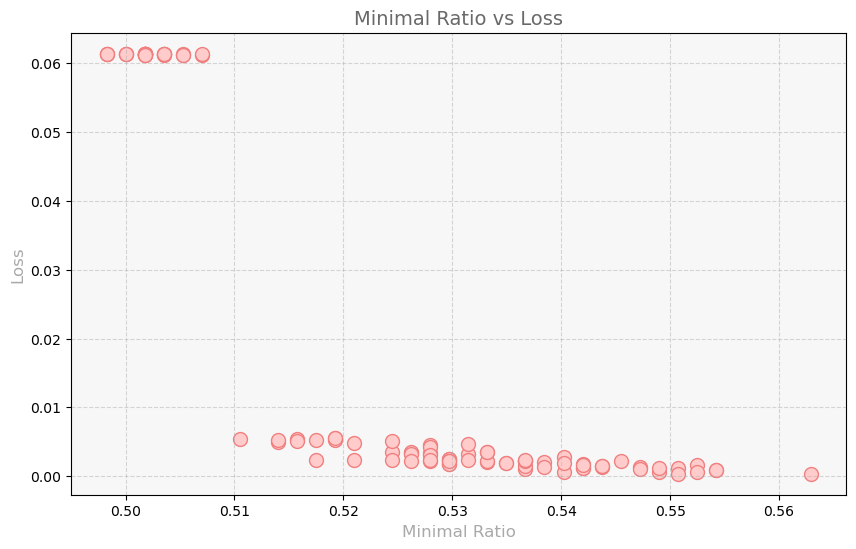

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Define the input
ip = np.expand_dims(np.arange(-1.5, 1.5, 0.01), 1)

# Use sinc() function to generate output
op = np.sinc(5 * ip)

# Convert numpy arrays to tensors
x = torch.tensor(ip, dtype=torch.float32)
y = torch.tensor(op, dtype=torch.float32)

# Define the neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 12)
        self.linear_4 = nn.Linear(12, 10)
        self.linear_5 = nn.Linear(10, 10)
        self.linear_6 = nn.Linear(10, 10)
        self.linear_7 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)
    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.linear_1(x))
        x = nn.functional.leaky_relu(self.linear_2(x))
        x = nn.functional.leaky_relu(self.linear_3(x))
        x = nn.functional.leaky_relu(self.linear_4(x))
        x = nn.functional.leaky_relu(self.linear_5(x))
        x = nn.functional.leaky_relu(self.linear_6(x))
        x = nn.functional.leaky_relu(self.linear_7(x))
        x = self.predict(x)
        return x

model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total params - ', total_params)

def train_model(model, x, y):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    
    # Initialize lossm_val and minimal_ratio
    lossm_val = None
    minimal_ratio = None
    
    print('Beginning training')
    
    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(x)
        lossm_val = 0.001
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())
        
        # Calculate the gradient
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)
        
        total_params = sum(p.numel() for p in model.parameters())
        if grad_norm < 0.001 or epoch == epoch_size:
            print('Gradient norm reached minimum value')
            predicted_y = model(x)
            lossm = loss_func(predicted_y, y)
            H = torch.zeros((total_params, total_params))

            Jacob = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
            Jacob = torch.cat([e.flatten() for e in Jacob])  # flatten
            for i in range(total_params):
                result = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([r.flatten() for r in result])  # flatten
            H_eig = torch.linalg.eigvalsh(H)  # UPDATED: Use torch.linalg.eigvalsh
            positive_count = sum(1 for val in H_eig if val > 0)
            minimal_ratio = positive_count / H.shape[0]
            print('Minimal Ratio - ', minimal_ratio, ' , Loss - ', lossm.data.detach().numpy(), ' Epoch - ', epoch)
            lossm_val = lossm.data.detach().numpy()
            break
    
    print('Training Completed')
    return lossm_val, minimal_ratio

loss_arr = []
min_ratio_arr = []

for index in range(100):
    print("Training model ", index)
    model = Model()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    loss_value, min_ratio = train_model(model, x, y)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

# Scatter plot for minimal ratio vs loss
plt.figure(figsize=(10, 6))
plt.scatter(min_ratio_arr, loss_arr, color="#ffcccb", edgecolors='lightcoral', s=100)  # Light red color
plt.xlabel("Minimal Ratio", fontsize=12, color="darkgrey")
plt.ylabel("Loss", fontsize=12, color="darkgrey")
plt.title("Minimal Ratio vs Loss", fontsize=14, color="dimgray")
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid
plt.gca().set_facecolor('#f7f7f7')  # Light background
plt.show()
